(00-backprop)=
# Backpropagation

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/nn/00-backprop.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

## Introduction

In this notebook, we look at **backpropagation** on directed acyclic compute graphs. Our main theoretical result is that a train step that consist of both a forward and a backward pass has a time complexity that is linear in the number of edges of the graph. This is interesting since it turns out that we can represent neural networks as computational graphs and this fact is what allows us to train large neural networks in practice. For neural networks, this time complexity is multiplied by the batch size. Our understanding of backpropagation allows us to implement a simple scalar-valued **autograd engine** with a neural net library on top it. To demonstrate that it works, we train a small regression model that models a sine wave.

**References:** {cite}`timviera` {cite}`backprop-offconvex` {cite}`pytorch-autograd` {cite}`micrograd`

## Gradient descent on the loss surface

For every data point $(\boldsymbol{\mathsf x}, \mathsf{y})$, the loss function $\ell$ returns a nonnegative value that approaches zero whenever the predictions $f_{\boldsymbol{\Theta}}(\boldsymbol{\mathsf x})$ approach the target values $\mathsf y$. The loss is designed to give penalty to bad predictions depending on the context or problem setup. More precisely, the loss acts as an almost-everywhere differentiable surrogate to the true objective which is generally non-differentiable metric (e.g. accuracy).

Training neural networks is essentially an optimization problem with the loss as objective. Given the current parameters $\boldsymbol{\Theta} \in \mathbb R^d$ of the network, we can imagine the network to be sitting on a point $(\boldsymbol{\Theta}, \mathcal L(\boldsymbol{\Theta}))$ on a surface in $\mathbb R^d \times \mathbb R$ where $\mathcal L(\boldsymbol{\Theta})$ is the average loss over the dataset:

$$
\mathcal L(\boldsymbol{\Theta}) = \frac{1}{|\mathcal X|} \sum_{(\boldsymbol{\mathsf x}, \mathsf{y}) \in \mathcal X} \ell(\mathsf{y}, f_{\boldsymbol{\Theta}}(\boldsymbol{\mathsf x})).
$$

The surface will generally vary for different samples of the training data, but we except the surfaces to be very similar assuming the samples are independently drawn from the same distribution. Training is equivalent to finding the minimum of this surface. The first derivatives give us information about the local slope of the surface which we can use to make the first-order approximation:

$$\Delta \mathcal L \approx  \sum_k \left(\frac{\partial \mathcal L}{ \partial {\Theta}_k} \right)  \Delta {\Theta}_k = \nabla_{\boldsymbol{\Theta}}\, \mathcal L \cdot \Delta {\boldsymbol{\Theta}}.$$ 

It follows that $-\nabla_{\boldsymbol{\Theta}}\, \mathcal L$ is the direction of steepest descent at the current point in the surface. The update rule 
$\boldsymbol{\Theta} \leftarrow \boldsymbol{\Theta} - \lambda \nabla_{\boldsymbol{\Theta}}\, \mathcal L$ where $\lambda > 0$ results in a network that is closer to the minimum of the loss surface.

**Remark.** The factor $\lambda$ is called the learning rate that controls the step size of the optimizer. Using a fixed learning rate can result in steps that overshoot the minimum, or too slow convergence. This explains why second-order methods which use second derivatives (i.e. the Hessian) are used to measure local surface curvature. This is impractical to compute for large number of weights. Instead, more commonly used methods combine adaptive learning rates and momentum for training large networks.

```{figure} ../../img/loss_surface_resnet.png
---
name: loss-surface-resnet
width: 35em
---
Loss surface for ResNet-56 with or without skip connections. Much of deep learning research is dedicated to studying the geometry of loss surfaces and its effect on optimization. {cite}`arxiv.1712.09913`
```

```{margin}
**The need for efficient BP**
```

Observe that $\nabla_{\boldsymbol{\Theta}}\, \mathcal L$ consists of partial derivatives for each weight in the network which can easily number in millions. Thus, we have to perform computation of derivatives in an efficient way for gradient-based optimization to be feasible. It turns out that this can be done with time complexity that is linear with the number of weights. Furthermore, the development of sophisticated hardware for parallel computation (e.g. GPUs) has reduced training time by a significant factor, resulting in the viability of neural network models for pratical uses.

**Remark.** Since the loss is a sum over pointwise losses, it suffices to compute gradients for loss surfaces generated by a single input-output pair $(\boldsymbol{\mathsf x}, \mathsf{y}) \in \mathcal X$ to compute the gradient of the empirical loss over $\mathcal X$ by linearity in $\nabla_{\boldsymbol{\Theta}}.$ In other words, computing the gradient is an embarassingly parallel task over the data points.
Indeed, our discussion and implementation below uses pointwise losses. 

## Backpropagation on computational graphs

A neural network can be modelled as a **directed acyclic graph** (DAG) of compute and parameter nodes that implements a function $f$ and can be extended to implement the calculation of the loss value for each training example and parameter values. Note that we can always perturb the value of the loss node at the current state of the graph (i.e. the current values of its nodes) by perturbing the values in each node. This results in perturbations flowing up to the final loss node. Assuming each computation is differentiable, we can compute the partial derivative of the loss with respect to each graph node. In this section, we will look at an algorithm for computing partial derivatives of computational graphs.

Our computational graph will consist of **compute nodes** and **parameter nodes**. A compute node simply implements a function of values of nodes that are directed to it. This doesn't have to implement atomic functions. In fact, we will implement compute nodes at various levels of abstraction. The choice generally depends on design considerations. On the other hand, parameter nodes simply store values which ultimately determines the function $f.$ In particular, our goal is to obtain parameter node values such that the resulting function minimizes the empirical loss.

To achieve this, we will use the fundamental property of directed acyclic graphs that it has a **topological sorting**. Observe that a DAG always has a node that has no outgoing edges (just follow a path until the last node). For our purposes, we know that this is precisely the loss node of our graph. Then, we can perform [Kahn's algorithm](https://www.youtube.com/watch?v=cIBFEhD77b4) starting with the loss node to determine the "layers" of the DAG, i.e. the order index of each node in the topological sorting.

```{figure} ../../img/compute.svg
---
width: 30%
name: compute
---
Compute and parameter node as input to another compute node. Note that parameter nodes always have zero fan-in.
```

### Forward pass

To compute $f(\boldsymbol{\mathsf x})$, the input $\boldsymbol{\mathsf x}$ is passed to the input nodes, then all compute nodes are executed up to the loss node following the directions and operations specified by the nodes and their edges. Note that node executions can occur asynchronously, e.g. in parallel. Moreover, each compute node is executed exactly once with the output value stored in the node. This will preserve the current network state for backward pass, and avoids any recomputation for nodes in the next layer. Assuming a node computes each incoming operation in constant time, then one forward pass has time and memory complexity $\mathcal{O}(\mathsf{E})$ where $\mathsf{E}$ is the number of edges of the graph. In the case of a neural network, the number of edges is proportional to the number of weights and activation units.

### Backward pass

We will assume that the graph has been topologically sorted. 
The gradient of the loss with itself is 1. This serves as the base step. Iterating backwards in the sorted list of nodes, we know that the gradient for each compute node ${\mathsf v}$ that depends on ${\mathsf u}$ is already stored. Note that all **local gradients** between ${\mathsf u}$ and ${\mathsf v}$ are analytically specified at definition and computed on the fly at runtime. Then the gradient with respect to node ${\mathsf u}$ can be calculated using the chain rule:

$$
{\frac{\partial\mathcal L}{\partial {{\mathsf u}}} } = \sum_{ {{j}} } {{\frac{\partial\mathcal L}{\partial{{\mathsf v}_j}}}} {{\frac{\partial{{\mathsf v}_j}}{\partial {{\mathsf u}}}}}.
$$

```{figure} ../../img/backward-1.svg
---
width: 80%
name: backward-1
---
Computing the backpropagated gradient for a single node. Note that gradient type is distinguished by color: local (red) and global (blue).
```

This can be visualized as gradients "flowing" to each network node from the loss node. Observe that the flow of gradients end on parameter nodes since these nodes have zero fan-in. Note that the partial derivatives are evaluated on the current network state with values obtained during forward pass. Hence, forward pass should always precede backward pass. Moreover, as required by the algorithm all backpropagated gradients are stored in each compute node for use by the next layer. Memory can be released after the weights are updated. On the other hand, there is no need to store local gradients; these are computed as needed. 
    
**Remark.** BP is a useful tool for understanding how derivatives flow through a model. This can be extremely helpful in reasoning about why some models are difficult to optimize. Well known examples are vanishing and exploding gradients as we go into deeper layers of the network.

### Backpropagation algorithm

Now that we know how to compute each backpropagated gradient, we can implement this as a method `u.backward()` for each node `u` that sends the gradient of the loss with respect to `u` to all nodes that depend on it. Every backpropagated gradient that is sent to a node is accumulated in a sum. Hence, we have to zero it out at the start of every trainng step.

```python
class CompGraph:
    # ...

    def forward(self, inputs):
        self.pass_inputs(inputs)
        for node in self.nodes_toposorted():
            node.forward()

    def backward():
        for node in self.nodes():
            node.grad = 0

        for node in reversed(self.nodes_toposorted()):
            node.backward()
```

<br>

Properties of the algorithm which makes it the practical choice for training huge neural networks are:

* **Modularity.** For neural networks, the dependence only on nodes belonging to the upper layer suggests a modularity in implementing neural networks, i.e. we can connect DAG subnetworks with possibly distinct network architectures by only connecting outermost nodes that are exposed between layers.

<br>

* **Efficiency.** Iterating over all nodes in the network during backward pass covers all the edges in the network with no edge counted twice. Assuming computing local gradients take constant time, then backward pass requires ${\mathcal O}(\mathsf{E})$ computations where $\mathsf{E}$ is the number of edges in the graph. For neural networks this is proportional to the number of neurons and parameters. Furthermore, the chain rule between nodes on the same layer and nodes in the upper layer of a network can be implemented as matrix multiplication for which there exist [highly optimized implementations](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms).

## Creating and training a neural net from scratch

Recall that all operations must be defined with its local gradient specified for efficient BP to work. In this section, we will implement a minimal **autograd engine** for creating computational graphs. This starts with the base `Node` class which has a `.data` attribute for storing output and a `.grad` attribute for storing the global gradient. The base class defines a `backward` method to solve for `.grad`:

```python
def backward(self):
    for parent in self._parents:
        parent.grad += self.grad * self._local_grad(parent)
        parent._degree -= 1
        if parent._degree == 0:
            parent.backward()
```

Each node has to wait for all incoming gradients from dependent nodes before passing the gradient to its parents. This works by having a `_degree` attribute that tracks whether all gradients from its dependent nodes have accumulated to a parent node. This is essentially [Kahn's algorithm](https://www.youtube.com/watch?v=cIBFEhD77b4&t=366s) for topological sorting. To get the correct degree, a newly created node starts with zero degree and is incremented each time a child node is created from it. In particular, the loss node has degree zero.

Note that the node class does not implement a local gradient. Instances of the node class, such as input nodes and network weights, are called **leaf nodes**. Nodes implement all operations and activations which are inherited by outputs of these computations which we call **compute nodes**. The formula for local gradient in `_local_grad` must be implemented with respect to each parent node of the compute node.

In [1]:
import math
import random
random.seed(42)

from typing import final


class Node:
    def __init__(self, data, parents=()):
        self.data = data
        self.grad = 0             # ∂(loss)/∂(self)
        self._degree = 0          # no. of children
        self._parents = parents   # terminal node 

    @final
    def backward(self):
        """Send global grads backward to parent nodes."""
        for parent in self._parents:
            parent.grad += self.grad * self._local_grad(parent)
            parent._degree -= 1
            if parent._degree == 0:
                parent.backward()
    
    def _local_grad(self, parent) -> float: 
        """Compute local grads ∂(self)/∂(parent)."""
        raise NotImplementedError("Base node has no parents.")

    def __add__(self, other):
        self._degree += 1
        other._degree += 1
        return BinaryOpNode(self, other, op='+')

    def __mul__(self, other):
        self._degree += 1
        other._degree += 1
        return BinaryOpNode(self, other, op='*')

    def __pow__(self, n):
        assert isinstance(n, (int, float)) and n != 1
        self._degree += 1
        return PowOp(self, n)

    def relu(self):
        self._degree += 1
        return ReLUNode(self)

    def tanh(self):
        self._degree += 1
        return TanhNode(self)

    def __neg__(self):
        return self * Node(-1)

    def __sub__(self, other):
        return self + (-other)

Note that we can take advantage of reduction to minimize the operations for which we have to implement `_local_grad(self, parent)`. Below, we define the above operations between nodes. Observe that only a handful of operations are needed to implement a fully-connected neural net!

In [2]:
class BinaryOpNode(Node):
    def __init__(self, x, y, op: str):
        """Binary operation between two nodes."""
        ops = {
            '+': lambda x, y: x + y,
            '*': lambda x, y: x * y
        }
        self._op = op
        super().__init__(ops[op](x.data, y.data), (x, y)) 

    def _local_grad(self, parent):
        if self._op == '+':
            return 1.0
                    
        elif self._op == '*':
            i = self._parents.index(parent)
            coparent = self._parents[1 - i]
            return coparent.data

    def __repr__(self):
        return self._op


class ReLUNode(Node):
    def __init__(self, x):
        data = x.data * int(x.data > 0.0)
        super().__init__(data, (x,))

    def _local_grad(self, parent):
        return float(parent.data > 0)

    def __repr__(self):
        return 'relu'


class TanhNode(Node):
    def __init__(self, x):
        data = math.tanh(x.data)
        super().__init__(data, (x,))

    def _local_grad(self, parent):
        return 1 - self.data**2

    def __repr__(self):
        return 'tanh'


class PowOp(Node):
    def __init__(self, x, n):
        self.n = n
        data = x.data ** self.n
        super().__init__(data, (x,))

    def _local_grad(self, parent):
        return self.n * parent.data ** (self.n - 1)

    def __repr__(self):
        return f"** {self.n}"

### Graph vizualization

The next two functions help to visualize networks. The `trace` function just walks backward into the graph to collect all nodes and edges. This is used by the `draw_graph` which first draws all nodes, then draws all edges. For compute nodes we add a small juncture node which contains the name of the operation.

In [3]:
# https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb
from graphviz import Digraph

def trace(root):
    """Builds a set of all nodes and edges in a graph."""

    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._parents:
                edges.add((child, v))
                build(child)
                    
    build(root)
    return nodes, edges


def draw_graph(root):
    """Build diagram of computational graph."""
    
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:

        # Add node to graph    
        uid = str(id(n))
        dot.node(name=uid, label=f"data={n.data:.3f} | grad={n.grad:.4f} | deg={n._degree}", shape='record')
        
        # Connect node to op node if operation
        # e.g. if (5) = (2) + (3), then draw (5) as (+) -> (5).
        if len(n._parents) > 0:
            dot.node(name=uid+str(n), label=str(n))
            dot.edge(uid+str(n), uid)

    for child, v in edges:
        # Connect child to the op node of v
        dot.edge(str(id(child)), str(id(v)) + str(v))
    
    return dot

Creating graph for a dense unit. Observe that `x1` has a degree of 2 since it has two children.

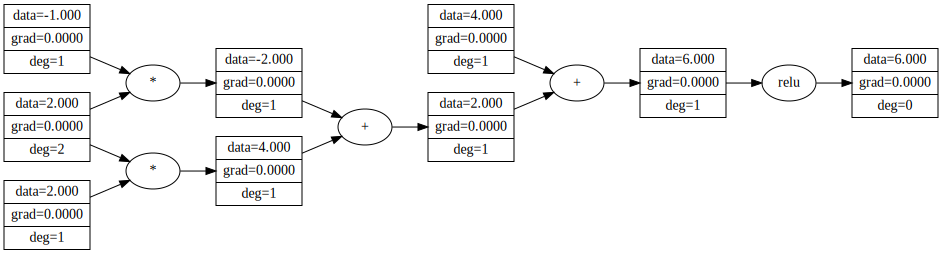

In [4]:
w1 = Node(-1.0)
w2 = Node( 2.0)
b  = Node( 4.0)
x  = Node( 2.0)
t  = Node( 3.0)

z = w1 * x + w2 * x + b
y = z.relu()
draw_graph(y)

Backward pass can be done by setting the initial gradient of the final node, then calling backward on it. Recall for the loss node `loss.grad = 1.0`. Observe that all gradients check out. Also, all degrees are zero, which means we did not overshoot the updates. This also means we can't execute `.backward()` twice.

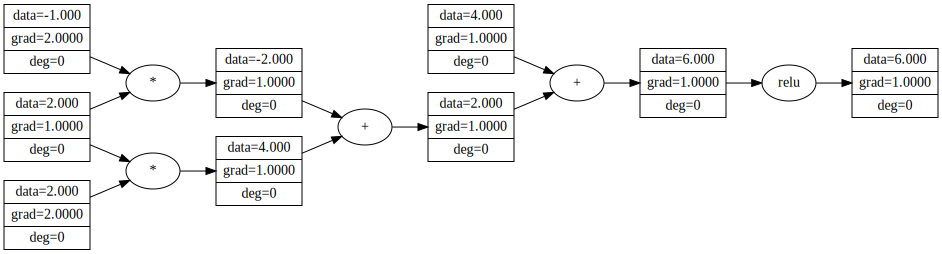

In [5]:
y.grad = 1.0
y.backward()
draw_graph(y)

### Neural network

In this section, we will construct the neural network module incrementally. First, we define an abstract class `Module` which is a computational graph that maintains a list of the parameter nodes used for computing `__call__` (i.e. operating on an input). The decorator `@final` means that overriding the `parameters()` method results in a warning (or an error with a type checker). This encourages defining `self._parameters` attribute so that the parameters list is not constructed at each call of the `parameters()` method.

In [6]:
from abc import ABC, abstractmethod

class Module(ABC):
    def __init__(self):
        self._parameters = []

    @final
    def parameters(self) -> list:
        return self._parameters

    @abstractmethod
    def __call__(self, x: list):
        pass

    @final
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

A neuron computes $\mathsf{o}_k = \varphi(\boldsymbol{\mathsf x} \cdot \boldsymbol{\mathsf w}_k + \mathsf{b}_k)$. A layer simply consists of multiple neurons. Finally, an MLP is just a stack of layers. Note that the final layer has no activation. This allows flexibility on the functions that we can apply to the outputs of the network.

In [7]:
import numpy as np
np.random.seed(42)

class Neuron(Module):
    def __init__(self, n_in, nonlinear=True, activation='relu'):
        self.n_in = n_in
        self.act = activation
        self.nonlin = nonlinear

        self.w = [Node(random.random()) for _ in range(n_in)]
        self.b = Node(0.0)
        self._parameters = self.w + [self.b] 

    def __call__(self, x: list):
        assert len(x) == self.n_in
        out = sum((x[j] * self.w[j] for j in range(self.n_in)), start=self.b)
        if self.nonlin:
            out = out.tanh() if self.act == 'tanh' else out.relu()
        return out

    def __repr__(self):
        return f"{self.act if self.nonlin else 'linear'}({len(self.w)})"


class Layer(Module):
    def __init__(self, n_in, n_out, *args):
        self.neurons = [Neuron(n_in, *args) for _ in range(n_out)]
        self._parameters = [p for n in self.neurons for p in n.parameters()]

    def __call__(self, x: list):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def __repr__(self):
        return f"Layer[{', '.join(str(n) for n in self.neurons)}]"


class MLP(Module):
    def __init__(self, n_in, n_outs, activation='relu'):
        sizes = [n_in] + n_outs
        self.layers = [Layer(sizes[i], sizes[i+1], i < len(n_outs)-1, activation) for i in range(len(n_outs))]
        self._parameters = [p for layer in self.layers for p in layer.parameters()]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def __repr__(self):
        return f"MLP[{', '.join(str(layer) for layer in self.layers)}]"

Testing model init and model call:

In [8]:
model = MLP(n_in=1, n_outs=[2, 2, 1])
print(model)
x = Node(1.0)
pred = model([x])
print(pred.data)

MLP[Layer[relu(1), relu(1)], Layer[relu(2), relu(2)], Layer[linear(2)]]
0.20429304314825944


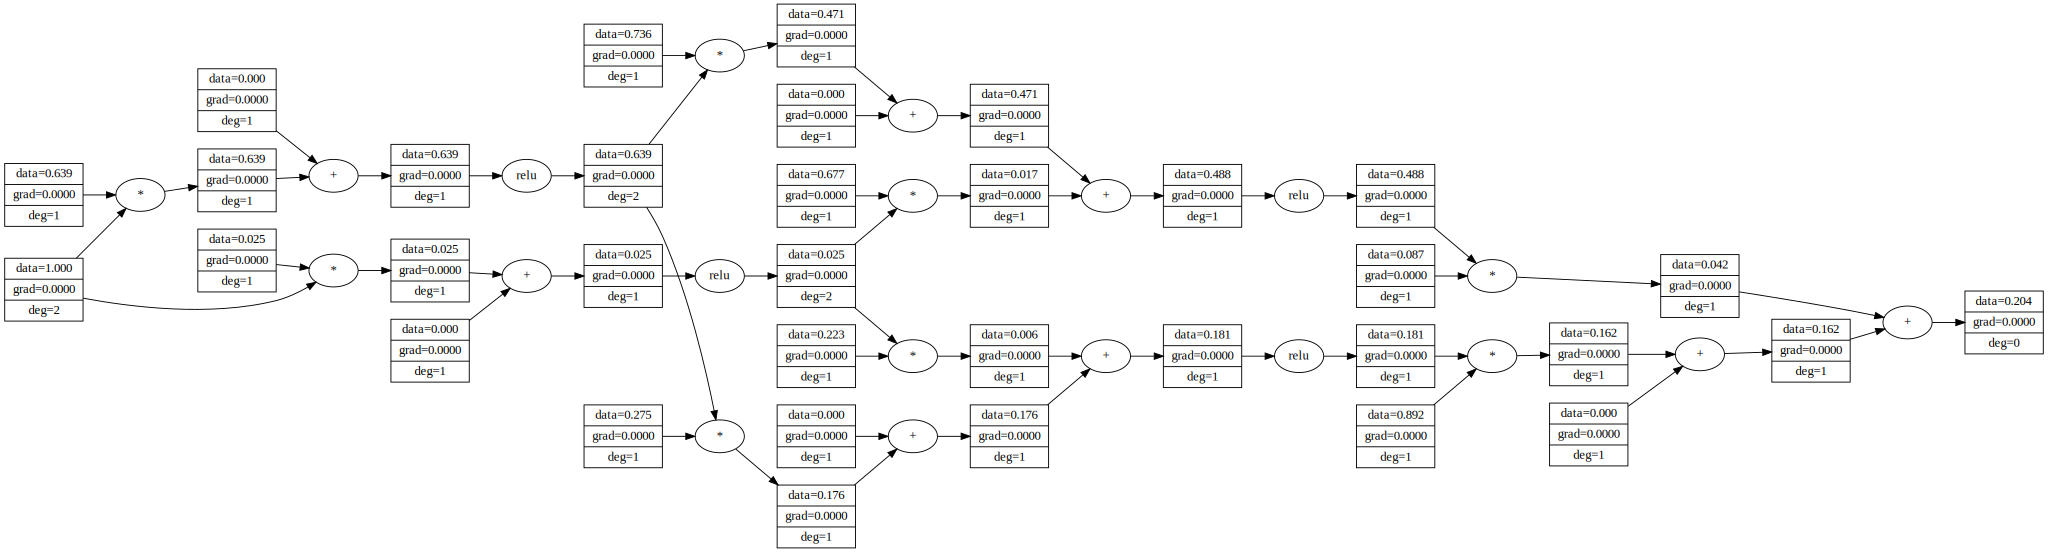

In [9]:
draw_graph(pred)

### Training the network!

To train a neural network that computes a function $f$, we can think of appending an extra node for the target values, and another compute node for the loss function. The node for the loss takes the output $f(\boldsymbol{\mathsf x})$ and target $\mathsf y$ for each input output pair $(\boldsymbol{\mathsf x}, {\mathsf y})$ in a training step. After computing the global gradients by backpropagation, we update the weights using [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) with `λ=0.0001`. SGD is just gradient descent combined with random sampling. 


**Dataset.** Our task is to learn the following signal consisting of 200 data points:

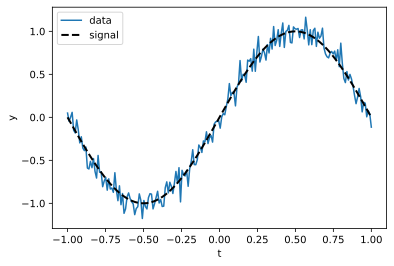

In [10]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

N = 200
time = np.linspace(-1, 1, N)
y_signal = np.sin(np.pi * time)
y_data = y_signal + 0.1 * np.random.normal(size=N)

plt.figure(figsize=(6, 4))
plt.plot(time, y_data, label='data')
plt.plot(time, y_signal, 'k--', label='signal', linewidth=2)
plt.ylabel('y')
plt.xlabel('t')
plt.legend();

**Data loader.** Helper for loading the samples:

In [11]:
import random

class DataLoader:
    def __init__(self, dataset):
        """Iterate over a partition of the dataset."""
        self.dataset = [(Node(x), Node(y)) for x, y in dataset]
    
    def load(self):
        return random.sample(self.dataset, len(self.dataset))

    def __len__(self):
        return len(self.dataset)

**Optimization.** The function `optim_step` implements one step of gradient descent. SGD uses a batch size of 1, so `loss_fn` just computes the MSE between two nodes.

In [12]:
def optim_step(model, eps):
    for p in model.parameters():
        p.data -= eps * p.grad 

def loss_fn(y_pred, y_true):
    return (y_pred - y_true)**2

**Trainer.** Running the training algorithm:

In [13]:
from tqdm.auto import tqdm

def train(model, dataset, epochs):
    dataloader = DataLoader(dataset)
    history = []
    for _ in tqdm(range(epochs)):
        for x, y in dataloader.load():
            model.zero_grad()
            
            loss = loss_fn(model([x]), y)
            loss.grad = 1.0
            loss.backward()
            optim_step(model, eps=0.0001)

            history.append(loss.data)

    return history


dataset = list(zip(time, y_data))
model = MLP(1, [3, 3, 1], 'tanh')
history = train(model, dataset, epochs=15000)

  0%|          | 0/15000 [00:00<?, ?it/s]

Observe that the loss curve becomes more stable as we train futher:

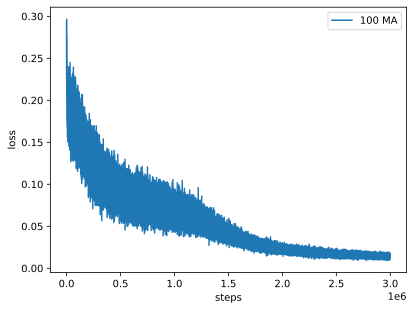

In [14]:
hist_ma = []
window_size = 100
for i in range(window_size, len(history)):
    hist_ma.append(sum(history[i-window_size:i]) / window_size)

plt.plot(hist_ma, label='100 MA')
plt.ylabel("loss")
plt.xlabel("steps")
plt.legend();

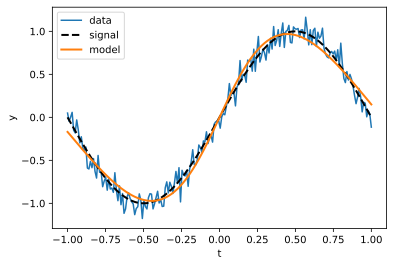

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(time, y_data, label='data', color='C0')
plt.plot(time, y_signal, 'k--', label='signal', linewidth=2)
plt.plot(time, [model([Node(_)]).data for _ in time], label='model', color='C1', linewidth=2)
plt.ylabel('y')
plt.xlabel('t')
plt.legend();

Evaluating with MAE since values are in (0, 1):

In [16]:
y_pred = np.array([model([Node(_)]).data for _ in time])
print(f"MAE (signal): {np.abs(y_pred - y_signal).mean():.2f}")
print(f"MAE (data):   {np.abs(y_pred - y_data  ).mean():.2f}")

MAE (signal): 0.05
MAE (data):   0.10


## Appendix:  PyTorch `autograd`

The `autograd` package allows automatic differentiation by building computational graphs on the fly every time we pass data through our model. Autograd tracks which data combined through which operations to produce the output. This allows us to take derivatives over ordinary imperative code. This functionality is consistent with the memory and time requirements outlined above for BP.

**Scalars.** Here we calculate $\mathsf{y} = \boldsymbol{\mathsf x}^\top \boldsymbol{\mathsf x} = \sum_i {\boldsymbol{\mathsf{x}}_i}^2$ where the initialized tensor $\boldsymbol{\mathsf{x}}$ initially has no gradient (i.e. `None`). Calling backward on $\mathsf{y}$ results in gradients being stored on the leaf tensor $\boldsymbol{\mathsf{x}}.$ Note that unlike our implementation, there is no need to set `y.grad = 1.0`. Moreover, doing so would result in an error as $\mathsf{y}$ is not a [leaf node](https://pytorch.org/docs/stable/generated/torch.Tensor.is_leaf.html) in the graph.

In [17]:
import torch
import torch.nn.functional as F
print(torch.__version__)

1.13.0


In [18]:
x = torch.arange(4, dtype=torch.float, requires_grad=True)
print(x.grad)

y = x.T @ x 
y.backward() 
print((x.grad == 2*x).all().item())

None
True


/var/folders/jq/9vsvd9252_349lsng_5gc_jw0000gn/T/ipykernel_64328/4003643635.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  y = x.T @ x


**Vectors.** Let $\boldsymbol{\mathsf y} = g(\boldsymbol{\mathsf x})$ and let $\boldsymbol{{\mathsf v}}$ be a vector having the same length as $\boldsymbol{\mathsf y}.$ Then `y.backward(v)` implements   

$$\sum_i {\boldsymbol{\mathsf v}}_i \frac{\partial {\boldsymbol{\mathsf y}}_i}{\partial {\boldsymbol{\mathsf x}}_j}$$ 
  
resulting in a vector of same length as $\boldsymbol{\mathsf{x}}$ stored in `x.grad`. Note that the terms on the right are the local gradients in backprop. Hence, if $\boldsymbol{\mathsf{v}}$ contains backpropagated gradients of nodes that depend on $\boldsymbol{\mathsf{u}}$, then this operation gives us the backpropagated gradients with respect to $\boldsymbol{\mathsf{x}}$, i.e. setting ${\boldsymbol{\mathsf v}}_i = \frac{\partial \mathcal{L} }{\partial \boldsymbol{\mathsf y}_i}$ gives us the vector $\frac{\partial \mathcal{L} }{\partial \boldsymbol{\mathsf x}_j}.$

In [19]:
x = torch.rand(size=(4,), dtype=torch.float, requires_grad=True)
v = torch.rand(size=(2,), dtype=torch.float)
y = x[:2]

# Computing the Jacobian by hand
J = torch.tensor(
    [[1, 0, 0, 0],
    [0, 1, 0, 0]], dtype=torch.float
)

# Confirming the above formula
y.backward(v)
(x.grad == v @ J).all()

tensor(True)

**Locally disable gradient tracking.** Disabling gradient computation is useful when computing values whose gradients will not be backpropagated into the network (e.g. performing evaluation with a metric or logging stuff). To stop PyTorch from building computational graphs, we can put the code inside a `torch.no_grad()` context or inside a function with a `@torch.no_grad()` decorator.

Another technique is to use the `.detach()` method which returns a new tensor detached from the current graph but shares the same storage with the original one. One must take care with in-place modifications on either. This may trigger errors in correctness checks.

## Appendix: Testing our engine with `autograd`

Here we use `autograd` to test our implementation of automatic differentiation:

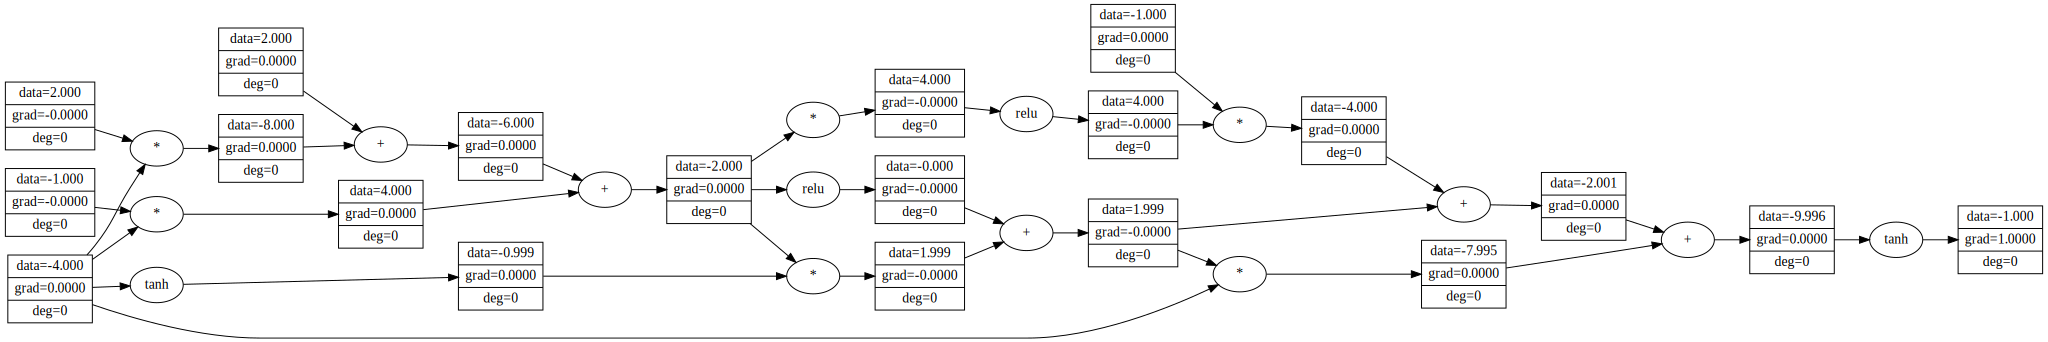

In [20]:
x = Node(-4.0)
z = Node(2) * x + Node(2) - x
q = z.relu() + z * x.tanh()
h = (z * z).relu()
y = (-h + q + q * x).tanh()
y.grad = 1.0
y.backward()

x_node, y_node, z_node = x, y, z
draw_graph(y_node)

In [21]:
x = torch.tensor(-4.0, requires_grad=True)
z = 2 * x + 2 - x
q = z.relu() + z * x.tanh()
h = (z * z).relu()
y = (-h + q + q * x).tanh()

z.retain_grad()
y.retain_grad()
y.backward()

x_torch, y_torch, z_torch = x, y, z

# forward
errors = []
errors.append(abs(x_node.data - x_torch.item()))
errors.append(abs(y_node.data - y_torch.item()))
errors.append(abs(z_node.data - z_torch.item()))

# backward
errors.append(abs(x_node.grad - x_torch.grad.item()))
errors.append(abs(y_node.grad - y_torch.grad.item()))
errors.append(abs(z_node.grad - z_torch.grad.item()))

print(f"Max absolute error: {max(errors):.2e}")

Max absolute error: 7.48e-08


(00-backprop:appendix-backpropagation-equations-for-mlps)=
## Appendix: Backpropagation equations for MLPs

In this section, we solve the backprop equations for a fully-connected neural net. This can be useful for analyzing gradient flow during training. Recall that a fully-connected layer with weights $\boldsymbol{\mathsf{w}}_{ij}$ and bias $\boldsymbol{\mathsf{b}}_j$ computes $\boldsymbol{\mathsf{y}}_j = \varphi(\sum_i \boldsymbol{\mathsf{x}}_i \boldsymbol{\mathsf{w}}_{ij} + \boldsymbol{\mathsf{b}}_j).$ The gradients can be nicely computed using [Einstein summation](https://www.dr-qubit.org/teaching/summation_delta.pdf) and dissecting the formula following its intermediate steps: 

$$
\begin{aligned}
\boldsymbol{\mathsf{y}}_j &= \varphi(\boldsymbol{\mathsf{z}}_j) \\ 
\boldsymbol{\mathsf{z}}_j &= \sum_i \boldsymbol{\mathsf{x}}_i \boldsymbol{\mathsf{w}}_{ij} + \boldsymbol{\mathsf{b}}_j.
\end{aligned}
$$

Given global gradients ${\partial \mathcal{L}}/{\partial \boldsymbol{\mathsf{z}}_j}$ that flows into the layer, we compute the global gradients of the nodes $\boldsymbol{\mathsf{z}}, \boldsymbol{\mathsf{x}}, \boldsymbol{\mathsf{w}},$ and $\boldsymbol{\mathsf{b}}$ in the layer. As discussed above, this can be done by carefully tracking backward dependencies in the compute graph.

```{figure} ../../img/fully-connected-backprop.drawio.svg
---
name: fully-connected-backprop.drawio
width: 50%
---
Node dependencies in compute nodes of a fully connected layer. All nodes $\boldsymbol{\mathsf{z}}_k$ depend on the node $\boldsymbol{\mathsf{y}}_j.$
```


Let ${\boldsymbol{\mathsf{J}}}^{\varphi}_{jk} = \frac{\partial \boldsymbol{\mathsf{y}}_j}{\partial \boldsymbol{\mathsf{z}}_k}$ be the [Jacobian](https://mathworld.wolfram.com/Jacobian.html) of $\varphi.$ Note that there can be cross-dependencies on activations such as softmax. But for typical activation functions the Jacobian reduces to a diagonal matrix. Following backward dependencies ({numref}`fully-connected-backprop.drawio`) for the compute nodes:

$$
\begin{aligned}
\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{z}}_j} &= \sum_k \frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{y}}_k} \left( \frac{\partial \boldsymbol{\mathsf{y}}_k}{\partial \boldsymbol{\mathsf{z}}_j} \right) =  \sum_k \frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{y}}_k} \boldsymbol{\mathsf{J}}^{\varphi}_{jk} \\
\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{x}}_i} &= \sum_j \frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{z}}_j} \left( \frac{\partial \boldsymbol{\mathsf{z}}_j}{\partial \boldsymbol{\mathsf{x}}_i} \right) =  \sum_j \frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{z}}_j} \boldsymbol{\mathsf{w}}_{ij}.
\end{aligned}
$$

In the above equations, we dropped the batch index since the operations can be carried out entirely within one instance of a batch. But observe that while only one preactivation node $\boldsymbol{\mathsf{z}}_j$ depends on the parameters $\boldsymbol{\mathsf{w}}_{ij}$ and $\boldsymbol{\mathsf{b}}_j$, all instances of that compute node within the batch depend on the current value of the parameter nodes. Hence, we have to account for batch-wise dependence when solving for their gradients:

$$
\begin{aligned}
\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{w}}_{ij}} &= \sum_b\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{z}}_{bj}} \left(\frac{\partial \boldsymbol{\mathsf{z}}_{bj}}{\partial \boldsymbol{\mathsf{w}}_{ij}}\right) =  \sum_b\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{z}}_{bj}} \boldsymbol{\mathsf{x}}_{bi} \\
\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{b}}_{j}} &= \sum_b\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{z}}_{bj}} \left( \frac{\partial \boldsymbol{\mathsf{z}}_{bj}} {\partial \boldsymbol{\mathsf{b}}_{j}} \right) =  \sum_b\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{z}}_{bj}}.
\end{aligned}
$$

This equation shows that the weight gradient depends on the gradient of the output (i.e. how the value output node directly influences the loss value) weighted by the input. This gradient is later weighted by $\frac{\lambda}{B}$ where $\lambda$ is the learning rate and $B$ is batch size. This also explains why we want to standardize inputs to the network and layer inputs. Otherwise, we effectively introduce multipliers to the learning rate on each input dimension.

```{figure} ../../img/weight-backprop.drawio.svg
---
name: weight-backprop.drawio
width: 30%
---
Node dependencies for a weight node. The nodes $\boldsymbol{\mathsf{z}}_{bj}$ depend on $\boldsymbol{\mathsf{w}}_{ij}$ for $b = 1, \ldots, B.$
```


### Cross entropy

In this section, we compute the gradient across the **cross-entropy** loss by symbolically differentiating its formula. This can be faster to perform and generally results in a cleaner and optimized formula than doing chain rule for all intermediate computation that each requires matrix multiplication if not simplified. Recall that [cross-entropy loss with logits](02-keras:api-for-cross-entropy) $\boldsymbol{\mathsf{s}}_{bj}$ computes 

$$
\begin{aligned}
\mathcal{L} 
&= -\frac{1}{B} \sum_b \log \frac{e^{\boldsymbol{\mathsf{s}}_{bt_b}}}{\sum_j e^{\boldsymbol{\mathsf{s}}_{bj}}} \\
&= -\frac{1}{B} \sum_b \left({\boldsymbol{\mathsf{s}}_{bt_b}} - \log \sum_j e^{\boldsymbol{\mathsf{s}}_{bj}} \right)
\\
&= -\frac{1}{B} \sum_b \left({\boldsymbol{\mathsf{s}}_{bt_b}} - \boldsymbol{\mathsf{s}}_{bj^*} - \log \sum_j e^{\boldsymbol{\mathsf{s}}_{bj} - \boldsymbol{\mathsf{s}}_{bj^*}} \right)
\end{aligned}
$$

where $\boldsymbol{\mathsf{s}}_{bj^*} = \max_j \boldsymbol{\mathsf{s}}_{bj}.$ This can be further decomposed into intermediate computations to get easier to compute derivatives. But this looks manageable. Our goal is to compute the derivative that flows to the logits $\boldsymbol{\mathsf{s}}_j.$ We differentiate the second equation above:

$$
\begin{aligned}
\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{s}}_{bk}}
&= -\frac{1}{B}\left(\boldsymbol{\delta}_{t_bk} - \frac{e^{\boldsymbol{\mathsf{s}}_{bk}}}{\sum_j e^{\boldsymbol{\mathsf{s}}_{bj}}}\right) = -\frac{1}{B}\left(\boldsymbol{\delta}_{t_bk} - \frac{e^{\boldsymbol{\mathsf{s}}_{bk} - \boldsymbol{\mathsf{s}}_{bj^*}}}{\sum_j e^{\boldsymbol{\mathsf{s}}_{bj} - \boldsymbol{\mathsf{s}}_{bj^*}}}\right)
\end{aligned}
$$

where $\boldsymbol{\delta}_{t_bk}$ denotes the [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta) tensor. Note that we adjust the exponentials for numerical stability similar to the last equality for $\mathcal L.$ It follows that 

$$
-\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{s}}_{bk}} 
=
-\frac{1}{B}\left(\boldsymbol{\delta}_{t_bk} - \boldsymbol{\mathsf{p}}_{bk} \right)
= 
\frac{1}{B}\begin{cases}
1 - \boldsymbol{\mathsf{p}}_{bt_b} & \;\; k = t_b \\
\boldsymbol{-\mathsf{p}}_{bj} & \;\; k \neq t_b.
\end{cases}
$$ 

where $\boldsymbol{\mathsf{p}}_{bt_b} = {e^{\boldsymbol{\mathsf{s}}_{bt_b} }}/{\sum_j e^{\boldsymbol{\mathsf{s}}_{bj} }}$ are the predict probabilities. Here we take the negative of the gradients to orient us in the direction of decreasing loss. Note that the negative gradient of the logit of the true class is always either positive or zero, while those of the other classes are always negative or zero. Moreover, the magnitude of the gradient of true class is equal to the magnitude of the other gradients combined.

**Dynamics of weight updates.** A neural network can be viewed as an extremely complex pulley system where adjusting one weight ultimately results in adjusting all positions of intermediate components up to the final loss. Since we are using gradient descent, we consider the first-order effect on the loss of perturbing a weight variable $\boldsymbol{\mathsf{w}}$ with all other weights of the system fixed. In particular, we consider its effects on the logits which are the outermost exposed neurons of the network:

$$
\begin{aligned}
-\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{w}}} 
&= -\sum_b\sum_k\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{s}}_{bk}} \frac{\partial \boldsymbol{\mathsf{s}}_{bk}}{\partial \boldsymbol{\mathsf{w}}} 
\\
&= -\frac{1}{B}\sum_b\sum_k\left(\boldsymbol{\delta}_{t_bk} - \boldsymbol{\mathsf{p}}_{bk} \right) \frac{\partial \boldsymbol{\mathsf{s}}_{bk}}{\partial \boldsymbol{\mathsf{w}}} \\
&= \frac{1}{B}\sum_b\left[(1 - \boldsymbol{\mathsf{p}}_{t_b}) \frac{\partial \boldsymbol{\mathsf{s}}_{t_b}}{\partial \boldsymbol{\mathsf{w}}} + \sum_{k \neq t_b} \boldsymbol{\mathsf{p}}_k \left(-\frac{\partial \boldsymbol{\mathsf{s}}_k}{\partial \boldsymbol{\mathsf{w}}}\right) \right].
\end{aligned}
$$ 

It follows that update for $\boldsymbol{\mathsf{w}}$ depends on how much it ultimately increases the true logits and decreases the other logits weighted by how close the probabilities are to the one-hot vector of the true class (i.e. the ideal probability vector) for that instance. In other words, if $\boldsymbol{\delta}_{t_b} \approx \boldsymbol{\mathsf{p}}_{b}$ for all $b$ in the batch, then the weight update $\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{w}}}$ is close to zero. This makes sense from a stability perspective.

In [22]:
B = 32
N = 27
t = torch.randint(low=0, high=N, size=(B,))
x = torch.randn(B, 128, requires_grad=True)
w = torch.randn(128, N, requires_grad=True)
b = torch.randn(N,      requires_grad=True)
z = x @ w + b
y = torch.tanh(z)

for node in [x, w, b, z, y]:
    node.retain_grad()

# Cross-entropy with logits y
loss = -torch.log(F.softmax(y, dim=1)[range(B), t]).sum() / B
loss.backward()

Plotting the gradient of the logits:

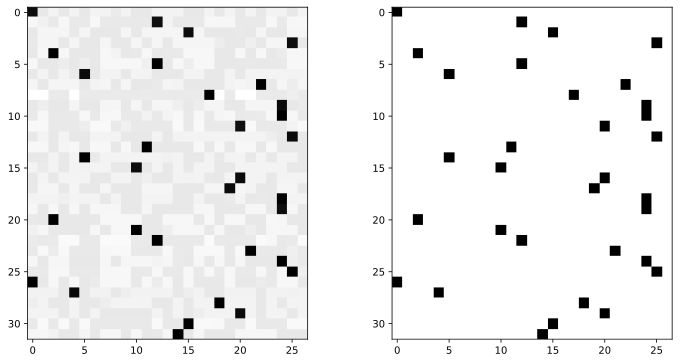

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(y.grad.detach().numpy() * B, cmap="gray")
ax[1].imshow(-F.one_hot(t, num_classes=N).detach().numpy(), cmap="gray");

**Figure.** Here ■ = 1, □ = 0. Plotted in the left are the gradient of the logits for the given batch. See above discussion. The actual targets are shown on the right. Each row of the update matrix sums to zero:

In [24]:
y.grad.sum(dim=1, keepdim=True).abs().mean()

tensor(1.8827e-09)

### Gradient checking

The above equations can be vectorized quite easily with the convention that the gradient with respect to a tensor $\boldsymbol{\mathsf{v}}$ has the same shape as $\boldsymbol{\mathsf{v}}.$ Let $\boldsymbol{\mathsf{v}}_\nabla = \frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{v}}}$ (i.e. `v.grad` in PyTorch code). Then we can write $\boldsymbol{\mathsf{x}}_\nabla = \boldsymbol{\mathsf{y}}_\nabla\,  \boldsymbol{\mathsf{w}}^\top$ since the input tensor $\boldsymbol{\mathsf{x}}$ is a row vector. For the sake of demonstration, we use a batch size of 32. This computation should give us an intuition of how gradients flow backwards through the neural net starting from the loss to all intermediate results.

In [25]:

J = 1 - y**2                        # Jacobian
δ_tk = F.one_hot(t, num_classes=N)  # Kronecker delta
dy = - (1 / B) * (δ_tk - F.softmax(y, dim=1))
dz = dy * J
dx = dz @ w.T
dw = torch.einsum('bi,bj->bij', (x, dz)).sum(dim=0, keepdim=True)
db = dz.sum(0, keepdim=True)

These equations can be checked using `autograd` as follows. Note that the computed gradients are inexact perhaps due to optimization in softmax. This can be seen above where we saw that the sum of gradients of the logits computed using `autograd` is nonzero.

In [26]:
def compare(name, dt, t):
    exact  = torch.all(dt == t.grad).item()
    approx = torch.allclose(dt, t.grad, rtol=1e-5)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{name:<3s} | exact: {str(exact):5s} | approx: {str(approx):5s} | maxdiff: {maxdiff:.2e}')


compare('y', dy, y)
compare('z', dz, z)
compare('x', dx, x)
compare('w', dw, w)
compare('b', db, b)

y   | exact: False | approx: True  | maxdiff: 1.86e-09
z   | exact: False | approx: True  | maxdiff: 2.33e-10
x   | exact: False | approx: True  | maxdiff: 6.98e-10
w   | exact: False | approx: True  | maxdiff: 7.45e-09
b   | exact: False | approx: True  | maxdiff: 4.66e-10
